# Leveraging AI to Improve Regression Outcomes

In [1]:
import os
import base64
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,make_scorer,mean_absolute_error
from sklearn.feature_selection import RFECV

from openai import OpenAI
from IPython.display import display, Markdown

client = OpenAI(
    api_key=os.environ.get("YOUR-APIKEY-HERE"),
)

In [2]:
def plot_pairplot(df, file_path):
    """
    Plots a pairplot of the selected numerical variables using a custom color palette and saves the plot.

    Parameters:
    df (pd.DataFrame): The dataframe containing numerical variables.
    file_path (str): The file path where the pairplot image will be saved.
    """
    # Define the custom color palette from the given HEX colors
    colors = ["#004242", "#3d6f6f", "#7b9b9b", "#b8c8c8", "#e1e6e6"]
    
    # Create the pairplot with adjusted aesthetics
    pairplot = sns.pairplot(df, diag_kind="kde", 
                            plot_kws={'alpha': 0.7, 'color': colors[1]}, 
                            diag_kws={'color': colors[2]}, 
                            palette=colors)  # Show all scatter plots & distributions
    
    # Adjust title and formatting
    pairplot.fig.suptitle("Pairplot of Numerical Variables", fontsize=14, y=1.02, color="black")

    # Format the axes to match the provided style but ensure black text and lines
    for ax in pairplot.axes.flatten():
        if ax:
            ax.set_xlabel(ax.get_xlabel(), fontsize=12, color="black")
            ax.set_ylabel(ax.get_ylabel(), fontsize=12, color="black")
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_color("black")
            ax.spines['bottom'].set_color("black")
            ax.xaxis.label.set_color("black")
            ax.yaxis.label.set_color("black")
            ax.tick_params(axis='both', colors="black")  # Keep ticks, but set to black

    # Save the figure
    pairplot.savefig(file_path, format="png", dpi=300)
    plt.show()

def plot_distributions(df, variables,file_path):
    """
    Plots the distributions of multiple variables in the dataframe in a grid layout with max 3 columns per row.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    variables (list): List of column names to plot.
    """
    num_vars = len(variables)
    num_cols = 3  # Maximum of 3 columns per row
    num_rows = int(np.ceil(num_vars / num_cols))  # Compute required rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4), squeeze=False)

    for i, var in enumerate(variables):
        row, col = divmod(i, num_cols)  # Determine subplot position
        sns.histplot(df[var], kde=True, bins=30, color='#004242', edgecolor='white', ax=axes[row, col])
        axes[row, col].set_title(f"Distribution of {var}", fontsize=12)
        axes[row, col].set_xlabel(var, fontsize=10)
        axes[row, col].set_ylabel("Frequency", fontsize=10)

        # Format y-axis numbers with comma separators
        axes[row, col].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))

        # Remove specific borders
        axes[row, col].spines['top'].set_visible(False)
        axes[row, col].spines['right'].set_visible(False)
        axes[row, col].spines['left'].set_visible(False)

    # Remove empty subplots if any
    for i in range(num_vars, num_rows * num_cols):
        row, col = divmod(i, num_cols)
        fig.delaxes(axes[row, col])

    plt.tight_layout()  # Adjust layout for better spacing
    plt.savefig(file_path, format="png", dpi=300)
    plt.show()

def plot_correlation_matrix(df,file_path):
    """
    Plots a heatmap of the correlation matrix using the provided color palette.

    Parameters:
    df (pd.DataFrame): The dataframe containing numerical variables.
    """

    # Define the custom color palette from the given HEX colors
    colors = ["#004242", "#3d6f6f", "#7b9b9b", "#b8c8c8", "#e1e6e6"]
    custom_cmap = LinearSegmentedColormap.from_list("custom_palette", colors, N=256)

    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=custom_cmap, 
                linewidths=0.5, cbar=True)

    # Title and aesthetics
    plt.title("Correlation Matrix", fontsize=14)
    
    # Remove borders for a cleaner look
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.savefig(file_path, format="png", dpi=300)
    plt.show()

def plot_regression(df, x_var, y_var, order,file_path):
    """
    Plots a scatter plot with a polynomial regression line using seaborn's lmplot.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    x_var (str): The column name for the x-axis.
    y_var (str): The column name for the y-axis.
    order (int): The polynomial order of the regression line.
    """
    # Define custom colors from the palette
    point_color = "#3d6f6f"   # Medium teal for scatter points
    line_color = "#004242"    # Dark teal for regression line
    edge_color = "white"      # White edges for scatter points

    # Create the regression plot
    plot = sns.lmplot(x=x_var, y=y_var, data=df, order=order, ci=None,
                      scatter_kws={"color": point_color, "edgecolor": edge_color, "alpha": 0.7, "s": 50},
                      line_kws={"color": line_color, "linewidth": 2})
    
    # Get the axes object
    ax = plot.ax

    # Set labels and title
    ax.set_xlabel(x_var, fontsize=12)
    ax.set_ylabel(y_var, fontsize=12)
    ax.set_title(f"Polynomial Regression (Order {order}) of {y_var} vs {x_var}", fontsize=14)

    # Format y-axis numbers with comma separators
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))

    # Remove top, right, and left borders (but keep axis labels)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.savefig(file_path, format="png", dpi=300)
    plt.show()

def plot_model_evaluation(y_test, y_pred,file_path):
    """
    Plots the Actual vs. Predicted values and the Residual Plot side by side for model evaluation.

    Parameters:
    y_test (array-like): Actual target values.
    y_pred (array-like): Predicted values from the model.
    """
    # Create a figure with two subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  

    # ---- 1️⃣ Actual vs. Predicted Plot ----
    sns.scatterplot(x=y_test, y=y_pred, color="#3d6f6f", edgecolor="white", alpha=0.7, s=50, ax=axes[0])

    # Add a reference diagonal line
    axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="#004242", linewidth=2)

    # Labels and Title
    axes[0].set_xlabel("Actual Salinity", fontsize=12)
    axes[0].set_ylabel("Predicted Salinity", fontsize=12)
    axes[0].set_title("Actual vs. Predicted Salinity", fontsize=14)

    # Remove top and right borders
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)

    # ---- 2️⃣ Residuals Plot ----
    residuals = y_test - y_pred
    sns.scatterplot(x=y_pred, y=residuals, color="#3d6f6f", edgecolor="white", alpha=0.7, s=50, ax=axes[1])

    # Add a horizontal reference line at 0
    axes[1].axhline(y=0, color="#004242", linestyle="--", linewidth=2)

    # Labels and Title
    axes[1].set_xlabel("Predicted Salinity", fontsize=12)
    axes[1].set_ylabel("Residuals (Error)", fontsize=12)
    axes[1].set_title("Residuals of the Model", fontsize=14)

    # Remove top and right borders
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(file_path, format="png", dpi=300)
    plt.show()

def plot_scatter_with_salinity(df, target='Salnty', variables=None, colors=None):
    """
    Plots scatter plots of multiple variables against Salinity (target) in a single figure.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    target (str): The target variable (default: 'Salnty').
    variables (list): List of variable names to plot against Salinity.
    colors (dict): Dictionary mapping variable names to colors.
    """

    if variables is None:
        variables = [col for col in df.columns if col != target]  # Select all except target

    if colors is None:
        # Default color mapping (if none provided)
        colors = {var: "#004242" for var in variables}  # Default to a single color

    plt.figure(figsize=(10, 10))

    for var in variables:
        plt.scatter(df[target], df[var], color=colors[var], alpha=0.5, label=var)  # Assigning unique colors correctly

    # Labels and Title
    plt.xlabel(target, fontsize=12)
    plt.ylabel("Variable Values", fontsize=12)
    plt.title(f'Scatter Plot of {target} vs Selected Variables', fontsize=14)

    # Move y-axis labels to the left
    plt.gca().yaxis.set_label_position("left")
    plt.gca().yaxis.tick_left()

    # Add legend
    plt.legend(loc='upper left')

    # Display plot
    plt.show()


def plot_correlation_heatmap(df_filtered,file_path):
    # Define the Teal Taiga color palette
    teal_taiga_palette = ["#004242", "#3d6f6f", "#7b9b9b", "#b8c8c8", "#e1e6e6"]
    
    # Create the heatmap with the adapted colors
    plt.figure(figsize=(10, 12)) 
    
    sns.heatmap(
        df_filtered.select_dtypes(['int64', 'int', 'float']).corr()[['Salnty']].sort_values(by='Salnty', ascending=False),
        annot=True,
        cmap=teal_taiga_palette,  # Usa la paleta de colores Teal Taiga
        linewidths=0.5,  # Ajusta el grosor de las líneas en blanco entre celdas
        linecolor="white",
        cbar=True
    )
    
    
    plt.title("Correlation Heatmap", fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.savefig(file_path, format="png", dpi=300)
    plt.show()

def plot_rfecv_results(rfecv, file_path):
    """
    Plots the R² scores from RFECV as horizontal bars with values at the end of each bar.
    
    Parameters:
    rfecv: fitted RFECV object
        The recursive feature elimination with cross-validation object after fitting.
    file_path: str
        Path to save the plot as a PNG file.
    """
    num_features = np.arange(1, len(rfecv.ranking_) + 1)
    scores = rfecv.cv_results_["mean_test_score"]
    
    # Sort by number of features in ascending order (so the highest number is on top)
    sorted_indices = np.argsort(num_features)
    num_features = num_features[sorted_indices]
    scores = scores[sorted_indices]
    
    # Define colors: highlight max score with main color, others in a lighter shade
    colors = ['#004242' if num == max(num_features) else '#66b2b2' for num in num_features]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(y=num_features, x=scores, palette=colors, edgecolor='white', orient='h')
    
    ax.set_ylabel("Number of Features Selected", fontsize=12)
    ax.set_xlabel("R² Score", fontsize=12)
    ax.set_title("Optimal Number of Features via RFECV", fontsize=14)
    
    # Remove specific borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(file_path, format="png", dpi=300)
    plt.show()

def encode_image(image_path):
    """
    Encodes an image to a Base64 string.

    Parameters:
    image_path (str): The file path to the image.

    Returns:
    str: Base64-encoded string representation of the image.
    """
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def analyze_image(client, prompt, image_path):  
    """
    Sends an image along with a text prompt to the OpenAI GPT-4o model for analysis.

    Parameters:
    client: OpenAI client instance.
    prompt (str): The text prompt describing the analysis or task.
    image_path (str): Path to the image file to be analyzed.

    Returns:
    None: Prints the model's response to the console.
    """
    # Encode the image as a Base64 string
    base64_image = encode_image(image_path)
    
    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    { "type": "text", "text": prompt },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                        },
                    },
                ],
            }
        ],
    )
    
    print(completion.choices[0].message.content)

def analyze_text(client, prompt):
    """
    Sends a text prompt to the OpenAI GPT-4o model for analysis.

    Parameters:
    client: OpenAI client instance.
    prompt (str): The text prompt to be analyzed.

    Returns:
    None: Prints the model's response to the console.
    """
    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": prompt
            }
        ],
    )

    print(completion.choices[0].message.content)

# Exploratory data analysis

In [3]:
df = pd.read_csv('data/bottle.csv')
df.head(5)

C:\Users\jmsm\AppData\Local\Temp\ipykernel_33012\2523774181.py:1: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/bottle.csv')


Cst_Cnt  Btl_Cnt       Sta_ID                                Depth_ID  \
0        1        1  054.0 056.0  19-4903CR-HY-060-0930-05400560-0000A-3   
1        1        2  054.0 056.0  19-4903CR-HY-060-0930-05400560-0008A-3   
2        1        3  054.0 056.0  19-4903CR-HY-060-0930-05400560-0010A-7   
3        1        4  054.0 056.0  19-4903CR-HY-060-0930-05400560-0019A-3   
4        1        5  054.0 056.0  19-4903CR-HY-060-0930-05400560-0020A-7   

   Depthm  T_degC  Salnty  O2ml_L  STheta  O2Sat  ...  R_PHAEO  R_PRES  \
0       0   10.50  33.440     NaN  25.649    NaN  ...      NaN       0   
1       8   10.46  33.440     NaN  25.656    NaN  ...      NaN       8   
2      10   10.46  33.437     NaN  25.654    NaN  ...      NaN      10   
3      19   10.45  33.420     NaN  25.643    NaN  ...      NaN      19   
4      20   10.45  33.421     NaN  25.643    NaN  ...      NaN      20   

   R_SAMP  DIC1  DIC2  TA1  TA2  pH2  pH1  DIC Quality Comment  
0     NaN   NaN   NaN  NaN  NaN  NaN  NaN                  NaN  
1     NaN   NaN   NaN  NaN  NaN  NaN  NaN                  NaN  
2     NaN   NaN   NaN  NaN  NaN  NaN  NaN                  NaN  
3     NaN   NaN   NaN  NaN  NaN  NaN  NaN                  NaN  
4     NaN   NaN   NaN  NaN  NaN  NaN  NaN                  NaN  

[5 rows x 74 columns]

In [4]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 864863 rows and 74 columns


As we have multiple columns containing important variables, let's begin with a simple analysis by exploring the relationship between salinity and temperature. To do this, we'll focus only on these two columns. Additionally, we will handle NaN values by removing them in our case. However, if you prefer to retain those data points, you can opt to replace them with either the most frequently occurring value or the previous value.

In [5]:
df = df[['Salnty', 'T_degC']]
df.columns = ['Salinity', 'Temperature']
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 864863 rows and 2 columns


In [6]:
df = df.dropna(subset=['Temperature', 'Salinity'])
#df['Temperature'].fillna(df['Temperature'].mode()[0], inplace=True)
#df['Salinity'].fillna(df['Salinity'].mode()[0], inplace=True)
#df[['Temperature', 'Salinity']] = df[['Temperature', 'Salinity']].fillna(method='bfill') #Backward fill
#df[['Temperature', 'Salinity']] = df[['Temperature', 'Salinity']].fillna(method='bfill') #Forward fill

nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 814247 rows and 2 columns


C:\Python310\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Python310\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Python310\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
C:\Python310\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)


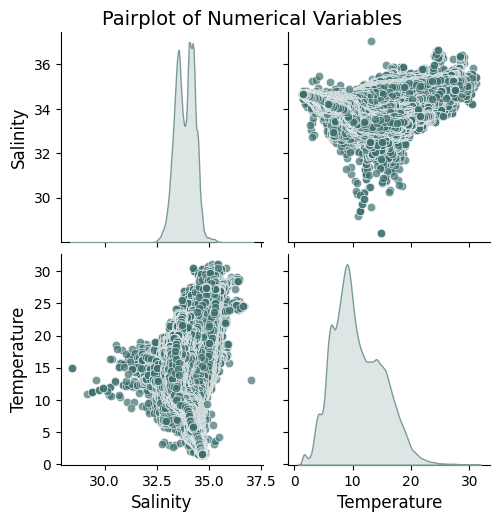

### Analysis of Pairplot: Temperature vs. Salinity

#### Correlation Strength and Direction
The scatter plot indicates a weak positive correlation between salinity and temperature. As salinity increases, there is a slight trend for temperature to increase. However, the points are quite dispersed, indicating the correlation is not strong.

#### Outliers
Several outliers are present, particularly at lower salinity levels with higher temperatures and vice versa. These outliers could significantly impact regression models by skewing results or influencing the slope of the regression line.

#### Clusters or Patterns
There appears to be a main cluster where the majority of data points lie, suggesting a general relationship between temperature and salinity. Additionally, there might be smaller sub-clusters or deviations, which may indicate varying conditions or other influencing factors.

#### Distribution of Variables
- **Salinity:** The distribution is relatively normal with slight peaks, s

<IPython.core.display.Markdown object>

In [7]:
file_path="pairplot.png"
plot_pairplot(df,file_path)
prompt = """
The following graph represents a pairplot analyzing the relationship between Temperature and Salinity. Please examine the scatter plot and marginal distributions to identify any significant patterns, trends, or anomalies.

Describe the correlation strength and direction between the two variables.
Identify any outliers that could impact a regression model.
Look for clusters or hidden patterns that may indicate additional factors influencing the relationship.
Analyze the distribution of each variable to determine if transformations might be beneficial.
Discuss the implications of these findings in an oceanographic or climate-related context.
Provide a concise yet insightful interpretation, and suggest any next steps to refine the analysis further. 
"""
markdown_output = analyze_image(client, prompt, file_path)  # Store the output first
# Display Markdown properly without returning an object
display(Markdown(markdown_output))

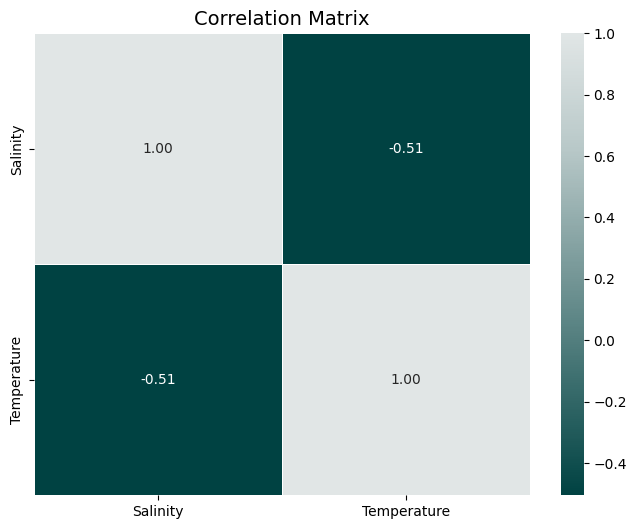

The correlation matrix shows the relationship between temperature and salinity, with a correlation coefficient of -0.51. This indicates a moderate negative correlation between the two variables. 

**Analysis:**

- **Correlation Strength:** The coefficient of -0.51 suggests a moderate inverse relationship. As temperature increases, salinity tends to decrease, and vice versa.

- **Anomalies:** No specific anomalies can be identified from the matrix alone, but the moderate negative correlation implies a consistent trend rather than isolated outliers.

**Potential Implications in an Oceanographic or Climate-Related Context:**

- **Ocean Circulation:** This inverse relationship could impact ocean density and circulation patterns. Warmer, less saline water is lighter and might lead to stratification, affecting marine life and nutrient distribution.

- **Climate Change:** As global temperatures rise, this relationship could become more pronounced, potentially leading to changes in evaporation

<IPython.core.display.Markdown object>

In [8]:
file_path="correlation_matrix1.png"
plot_correlation_matrix(df,file_path)
prompt = """The following graph represents the correlation matrix between Temperature and Salinity. 
Please analyze the relationship between these two variables. 
Identify significant correlations, anomalies. Additionally, discuss any potential implications of these relationships in an oceanographic 
or climate-related context"""

markdown_output = analyze_image(client, prompt, file_path)  # Store the output first
# Display Markdown properly without returning an object
display(Markdown(markdown_output))

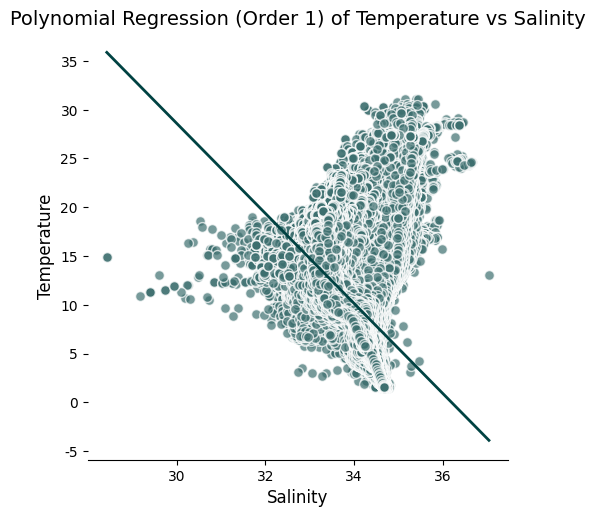

The analysis of the graph showing the first-order regression between Temperature and Salinity reveals several key points:

### Relationship and Strength of Fit
1. **Negative Correlation**: The regression line indicates a negative correlation between temperature and salinity. As salinity increases, temperature tends to decrease.
   
2. **Strength of Fit**: The linear regression line doesn't capture much of the variability in the data, suggesting a weak fit. The scatterplot shows a high dispersion around the line, meaning the linear model may not accurately represent the relationship.

### Notable Patterns and Anomalies
1. **Data Clustering**: Data points cluster heavily around a range of salinity values, indicating a possible non-linear relationship that isn’t captured by a first-order regression.

2. **Potential Anomalies**: Outliers or data points significantly deviating from the pattern could affect the regression line and may need further investigation.

### Environmental/Oceanograp

<IPython.core.display.Markdown object>

In [9]:
file_path="regression_order1.png"
plot_regression(df, 'Salinity', 'Temperature', 1, file_path)
prompt = """The following graph represents a first-order regression analysis between Temperature and Salinity. 
Please analyze the relationship, and the strength of the regression fit. 
Discuss any notable patterns, potential anomalies, and the implications of this relationship in an environmental 
or oceanographic context. Additionally, assess whether a first-order regression is an appropriate model for this data 
or if a higher-order regression might provide better insights."""

markdown_output = analyze_image(client, prompt, file_path)  # Store the output first
# Display Markdown properly without returning an object
display(Markdown(markdown_output))

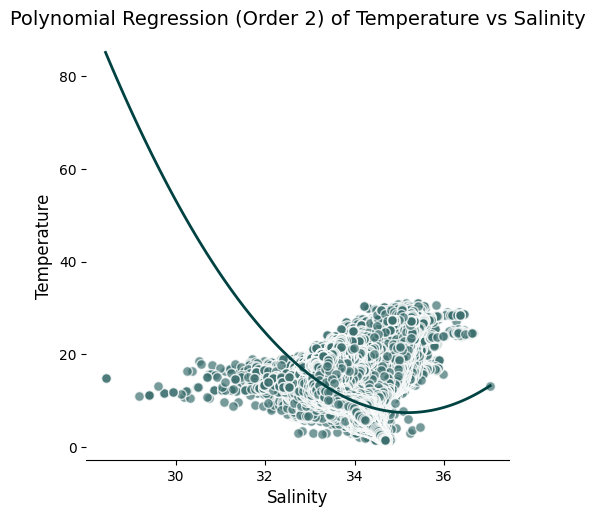

The graph presents a second-order polynomial regression between temperature and salinity. Here's an analysis of the relationship:

### Relationship and Strength of Fit

1. **Second-Order Polynomial Fit**: The curve indicates a quadratic relationship between temperature and salinity. The decrease in temperature as salinity increases is clear, suggesting an inverse relationship.

2. **Fit Strength**: Visual inspection shows that the model captures the general trend, but there is significant variability around the curve, indicating that the fit may not be very strong. The data points are widely dispersed, especially in the lower salinity range.

### Notable Patterns and Anomalies

1. **Patterns**: 
   - The curve decreases sharply as salinity increases from 30 to about 34. 
   - After reaching a minimum, it slightly increases at higher salinity values, forming a U-shape characteristic of quadratic models.

2. **Anomalies**:
   - There is a concentration of data points at higher temperatur

<IPython.core.display.Markdown object>

In [10]:
file_path="regression_order2.png"
plot_regression(df, 'Salinity', 'Temperature', 2, file_path)
file_path="regression_order2.png"
prompt = """The following graph represents a second-order regression analysis between Temperature and Salinity. 
Please analyze the relationship, and the strength of the regression fit. 
Discuss any notable patterns, potential anomalies, and the implications of this relationship in an environmental 
or oceanographic context. Additionally, assess if this regression is an appropriate model for this data 
or if a higher-order regression might provide better insights."""

markdown_output = analyze_image(client, prompt, file_path)  # Store the output first
# Display Markdown properly without returning an object
display(Markdown(markdown_output))

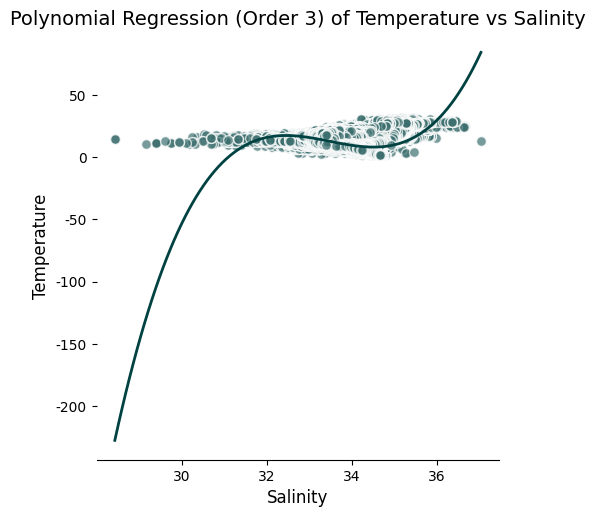

The third-order polynomial regression curve in the graph suggests a complex relationship between Temperature and Salinity. Here's an analysis based on what is visible:

### Relationship and Regression Fit
- **Trend**: The graph shows a nonlinear relationship, with the curve initially decreasing sharply before leveling out and then increasing again at higher salinity levels.
- **Strength of Fit**: The alignment of the curve with the data points suggests that the third-order polynomial captures the general trend. The fit seems appropriate in the range where data points are densely packed.

### Patterns and Anomalies
- **Notable Patterns**: There appears to be a critical point around which the temperature remains fairly constant despite changes in salinity. Beyond certain salinity levels, temperature increases significantly.
- **Potential Anomalies**: Any outlier points could indicate measurement errors or unique conditions where the general temperature-salinity relationship does not hold

<IPython.core.display.Markdown object>

In [11]:
file_path="regression_order3.png"
plot_regression(df, 'Salinity', 'Temperature', 3, file_path)
prompt = """The following graph represents a third-order regression analysis between Temperature and Salinity. 
Please analyze the relationship, and the strength of the regression fit. 
Discuss any notable patterns, potential anomalies, and the implications of this relationship in an environmental 
or oceanographic context. Additionally, assess if this regression is an appropriate model for this data 
or if a higher-order regression might provide better insights."""

markdown_output = analyze_image(client, prompt, file_path)  # Store the output first
# Display Markdown properly without returning an object
display(Markdown(markdown_output))

# The model
## Training & Evaluating the model

In [12]:
X = df[['Temperature']]   # Predictor (Temperature)
y = df['Salinity']     # Target (Salinity)

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
model = LinearRegression() # Initialize the linear regression model
model.fit(X_train, y_train)# Train the model on the training data
# Get model parameters
slope = model.coef_[0]  # Regression coefficient
intercept = model.intercept_  # Intercept
text=f"📌 Model Equation: Salinity = {slope:.3f} * Temperature + {intercept:.3f}"

# Predict Salinity for the test set
y_pred = model.predict(X_test)

# Calculating errors
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) 
r2 = r2_score(y_test, y_pred)

# Shwoing results
print(f"📊 Evaluating the model:")
print(f"🔹 Mean Absolute Error (MAE): {mae:.3f}")
print(f"🔹 Mean Squared Error (MSE): {mse:.3f}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"🔹 R² Score: {r2:.3f}")

prompt = f"""
The following equation represents a linear regression model that describes the relationship between salinity and temperature:

{text}

### Model Performance Metrics:
- **Mean Absolute Error (MAE)**: {mae:.3f}
- **Mean Squared Error (MSE)**: {mse:.3f}
- **Root Mean Squared Error (RMSE)**: {rmse:.3f}
- **R² Score (Coefficient of Determination)**: {r2:.3f}

### Analysis Required:
1️⃣ **Interpretation of Model Components**:
   - Explain the meaning of the **slope** and **intercept**, and how they influence salinity predictions.
   - Discuss whether the relationship is **positive or negative** and its implications.

2️⃣ **Model Performance Evaluation**:
   - Assess the **accuracy and reliability** of the model based on the given performance metrics.
   - What do the MAE, MSE, RMSE, and R² values suggest about the model’s predictive power?
   - Are there indications of **overfitting or underfitting**?

3️⃣ **Limitations and Assumptions**:
   - What are the potential **limitations** of using a linear regression approach for this relationship?
   - Does the model assume a **strictly linear** relationship, and is this valid for oceanographic data?

4️⃣ **Real-World Implications**:
   - How does this relationship between temperature and salinity relate to **oceanographic, climate, or environmental** studies?
   - Could external factors (e.g., depth, pressure, currents) influence salinity beyond just temperature?

5️⃣ **Potential Model Improvements**:
   - Would a **higher-order regression** (quadratic or polynomial) provide a better fit?
   - Should additional **predictor variables** be included to improve accuracy?

Please provide a **detailed, structured, and insightful analysis** of this model.
"""

analyze_text(client, prompt)

📊 Evaluating the model:
🔹 Mean Absolute Error (MAE): 0.280
🔹 Mean Squared Error (MSE): 0.160
🔹 Root Mean Squared Error (RMSE): 0.399
🔹 R² Score: 0.252
Certainly! Here's a comprehensive analysis of the linear regression model and its implications:

### 1️⃣ Interpretation of Model Components

- **Slope**: The slope of the regression model is -0.055. This indicates that for every one-unit increase in temperature, the salinity decreases by 0.055 units. The negative slope denotes an inverse relationship between temperature and salinity, suggesting that higher temperatures are associated with lower salinity levels.

- **Intercept**: The intercept is 34.441. This is the predicted salinity when the temperature is zero. While this is a theoretical value, as ocean temperatures do not reach zero degrees in a conventional context, it provides a baseline from which changes in salinity with temperature are measured.

- **Implications**: The negative relationship implies potential physical processes 

## Evaluating the model and analyzing errors

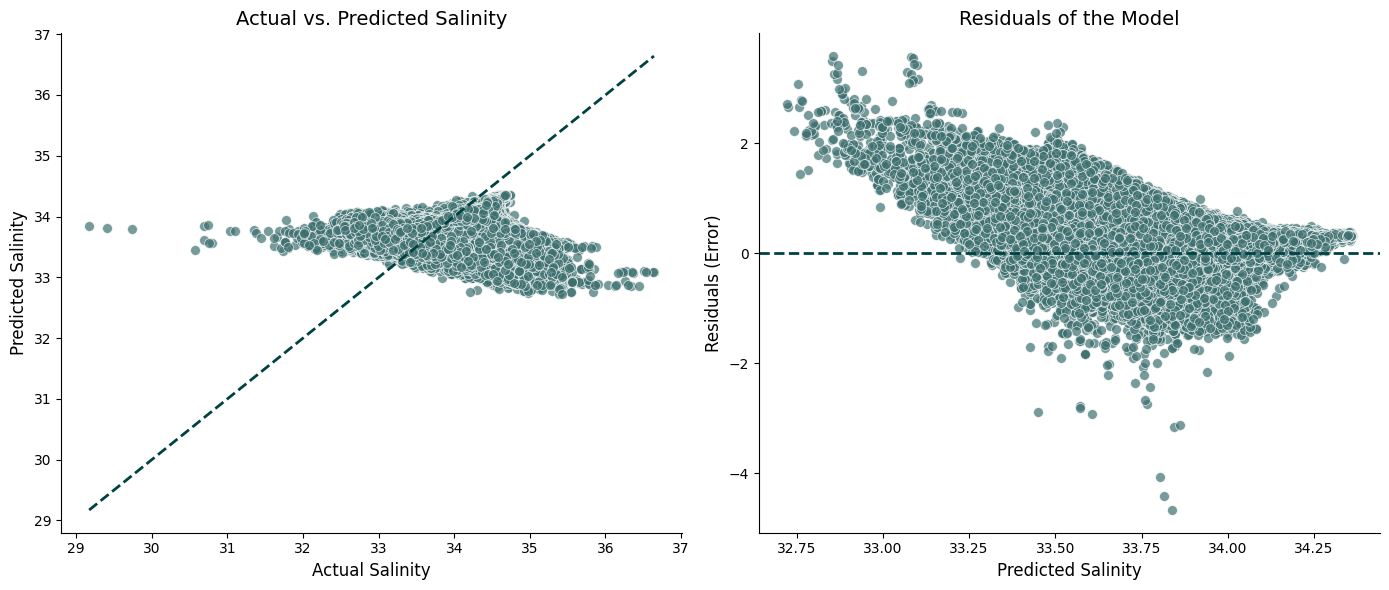

### 1️⃣ Model Performance Evaluation:

- **Alignment of Values**:
  - The plot shows a deviation from the ideal 45-degree line, indicating discrepancies between actual and predicted values. The model seems to predict a narrower range of values than observed in reality.
  
- **Systematic Deviations**:
  - There is evidence of systematic underprediction for higher actual values (e.g., above 34) and overprediction for lower actual values. This suggests potential bias in the model, especially at the extremes.
  
- **Bias or Consistent Errors**:
  - The consistent deviations from the ideal line suggest the existence of bias, possibly due to unconsidered variables or an oversimplified model.

### 2️⃣ Residual Analysis:

- **Distribution of Residuals**:
  - The residuals display a funnel shape, widening as predicted values increase. This indicates heteroscedasticity, where variance is not constant.

- **Patterns and Non-linearity**:
  - The funnel pattern and clustering of points suggest non-

<IPython.core.display.Markdown object>

In [14]:
file_path="actual_predictive_residuals.png"
plot_model_evaluation(y_test, y_pred, file_path)

prompt = """
The following graph represents the **Actual vs. Predicted values** and the **Residuals** of a regression model. 

### **Analysis Required:**
1️⃣ **Model Performance Evaluation**:
   - Assess how well the **predicted values align with the actual values**.
   - Identify whether there are **systematic deviations** (e.g., underprediction or overprediction in certain ranges).
   - Discuss if the model exhibits **bias** or consistent errors.

2️⃣ **Residual Analysis**:
   - Examine the **distribution of residuals** to determine whether errors are randomly distributed.
   - Identify any **patterns, heteroscedasticity (variance changes), or skewness**.
   - Assess if residuals indicate **non-linearity**, suggesting the need for a different modeling approach.

3️⃣ **Error Insights**:
   - Identify potential **outliers** that may be influencing the model.
   - Discuss whether the model suffers from **overfitting or underfitting** based on residual behavior.
   - Evaluate whether **additional features or transformations** could improve the model's accuracy.

4️⃣ **Real-World Implications**:
   - How do the observed errors impact decision-making or predictions in the given context (e.g., climate studies, environmental forecasting, business insights)?
   - If the model is deployed, what are the risks associated with its error patterns?

Please provide a **structured and detailed analysis** based on these insights.
"""

markdown_output = analyze_image(client, prompt, file_path)  # Store the output first
# Display Markdown properly without returning an object
display(Markdown(markdown_output))

# Multivaraible Regression Analysis

It is evident that using only one variable is not sufficient to accurately predict salinity. Let's explore whether we can enhance our model by incorporating additional variables from the dataset to improve its predictive performance.

In [15]:
df = pd.read_csv('data/bottle.csv')
df.head(5)
df_filtered = df.loc[:, ~df.columns.str.startswith("R_")]


C:\Users\jmsm\AppData\Local\Temp\ipykernel_33012\2873004501.py:1: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/bottle.csv')


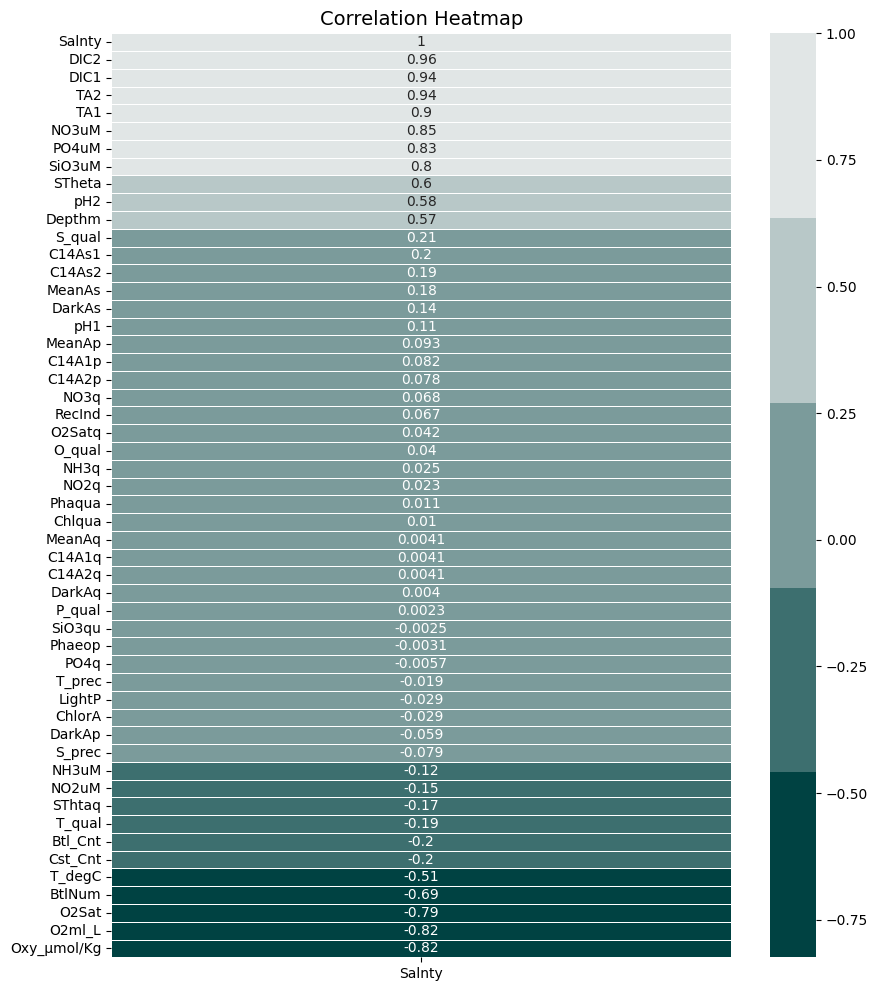

### Analysis of the Correlation Heatmap

#### Strong Positive Correlations:
- **Salnity and DIC2, DIC1**: High correlation (0.96 and 0.94) indicates strong positive relationships. Changes in DIC levels are closely linked with changes in Salinity.
- **Salnity and TA2, TA1**: Very strong positive correlation (0.94 and 0.90) suggests that Total Alkalinity is highly dependent on Salinity.
- **Salnity and NO3UM, PO4UM, SiO3UM**: Correlations range from 0.80 to 0.85, showing a strong positive relationship with nutrient levels.

#### Strong Negative Correlations:
- **Salnity and O2sat**: Strong negative correlation (-0.79) suggests that as Salinity increases, Oxygen saturation decreases.
- **Salnity and O2ml_L, Oxy_µmol/Kg**: Both have a correlation of -0.82, indicating a significant drop in oxygen content as Salinity rises.
- **Salnity and BtlNum**: A correlation of -0.69 indicates a notable decrease in BtlNum with increasing Salinity. 

#### Potential Multicollinearity Issues:
- Variables s

<IPython.core.display.Markdown object>

In [16]:
file_path="correlation_heatmap.png"
plot_correlation_heatmap(df_filtered, file_path)
prompt = """The following graph represents a correlation heatmap of all available variables in the dataset. 

Please analyze the relationships between the variables, identifying:
- Strong positive or negative correlations.
- Potential multicollinearity issues.
- Key variables that may have the most influence on the target variable.
- Any unexpected or interesting patterns in the data.

Provide a structured and insightful interpretation based on the heatmap."""

markdown_output = analyze_image(client, prompt, file_path)  # Store the output first
# Display Markdown properly without returning an object
display(Markdown(markdown_output))



In [17]:
# Select numerical columns and compute correlation with 'Salnty'
correlation_with_salnty = df_filtered.select_dtypes(['int64', 'int', 'float']).corr()[['Salnty']]
high_correlation_vars = correlation_with_salnty[abs(correlation_with_salnty['Salnty']) > 0.5]
var_selection=high_correlation_vars.index.tolist()
# List of variables to exclude
vars_to_exclude = ['DIC1', 'DIC2', 'TA1', 'TA2', 'pH2']
# Filter the variable selection list
filtered_var_selection = [var for var in var_selection if var not in vars_to_exclude]

In [18]:
df_high_corr = df_filtered[filtered_var_selection]

In [19]:
df_cleaned = df_high_corr.dropna()
df_cleaned

Depthm  T_degC   Salnty  O2ml_L    STheta   O2Sat  Oxy_µmol/Kg  \
683767       1  14.260  33.3960   6.050  24.89400  103.80     263.6302   
683768       6  14.290  33.3960   6.060  24.88800  104.00     264.0675   
683770      12  14.300  33.4010   6.060  24.89000  104.00     264.0670   
683772      22  14.320  33.4060   6.030  24.89000  103.50     262.7597   
683774      31  14.230  33.4110   5.990  24.91300  102.70     261.0108   
...        ...     ...      ...     ...       ...     ...          ...   
864857     521   5.818  34.2382   0.366  26.98477    5.23      15.9500   
864859       2  18.744  33.4083   5.805  23.87072  108.74     253.4700   
864860       5  18.692  33.4150   5.796  23.88911  108.46     253.0600   
864861      10  18.161  33.4062   5.816  24.01426  107.74     253.9200   
864862      15  17.533  33.3880   5.774  24.15297  105.66     252.0800   

        BtlNum  PO4uM  SiO3uM  NO3uM  
683767     1.0   0.41    4.80   0.20  
683768     2.0   0.39    4.50   0.10  
683770     3.0   0.40    4.30   0.10  
683772     4.0   0.39    4.20   0.20  
683774     5.0   0.41    4.20   0.20  
...        ...    ...     ...    ...  
864857     1.0   3.09   77.58  40.98  
864859     4.0   0.22    1.77   0.10  
864860     3.0   0.20    1.75   0.09  
864861     2.0   0.25    1.99   0.11  
864862     1.0   0.31    2.58   0.14  

[109946 rows x 11 columns]

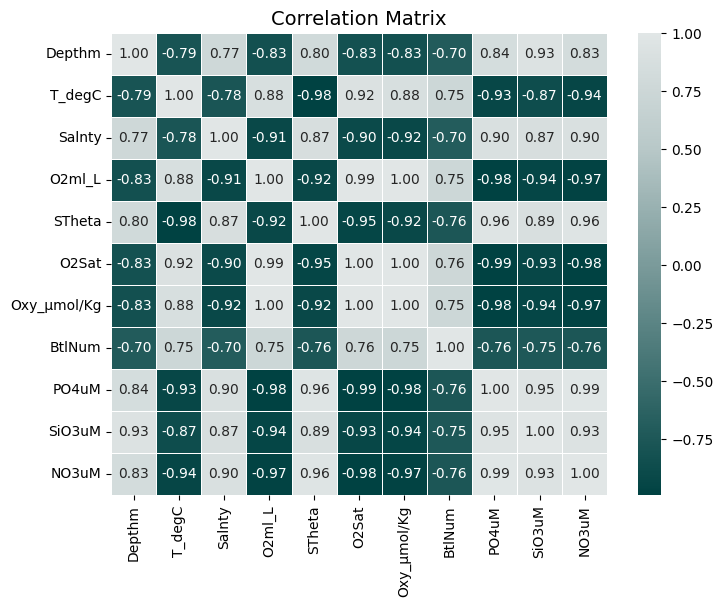

The correlation matrix shows the relationships between different oceanographic variables, including temperature (T_degC) and salinity (Salnty).

### Key Relationships:
1. **Temperature and Salinity**:
   - Correlation: -0.78
   - Interpretation: There is a strong negative correlation, indicating that as temperature increases, salinity tends to decrease and vice versa.

2. **Temperature with Other Variables**:
   - **Negative correlations**:
     - Strong negative correlation with potential density (STheta) (-0.98), suggesting warmer waters are less dense.
     - Negative correlation with nutrient concentrations (P04uM, SiO3uM, NO3uM), indicating nutrient levels tend to be lower in warmer waters.

   - **Positive correlations**:
     - Strong positive correlation with oxygen saturation (O2Sat) (0.92), suggesting warmer water might be more oxygenated under certain conditions.

3. **Salinity with Other Variables**:
   - **Negative correlations**:
     - Negative correlation with oxygen-re

<IPython.core.display.Markdown object>

In [20]:

file_path="correlation_heatmap2.png"
plot_correlation_matrix(df_cleaned, file_path)

prompt = """The following graph represents the correlation matrix between Temperature and Salinity. 
Please analyze the relationship between these two variables. 
Identify significant correlations, anomalies. Additionally, discuss any potential implications of these relationships in an oceanographic 
or climate-related context"""

markdown_output = analyze_image(client, prompt, file_path)  # Store the output first
# Display Markdown properly without returning an object
display(Markdown(markdown_output))


# Feature Selection applying Recursive Feature Elimination

In [21]:
selected_features=['Depthm', 'T_degC', 'Salnty', 'O2ml_L', 'STheta', 'O2Sat',
       'Oxy_µmol/Kg', 'BtlNum', 'PO4uM', 'SiO3uM', 'NO3uM']

C:\Python310\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Python310\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Python310\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Python310\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Python310\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Python310\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\P

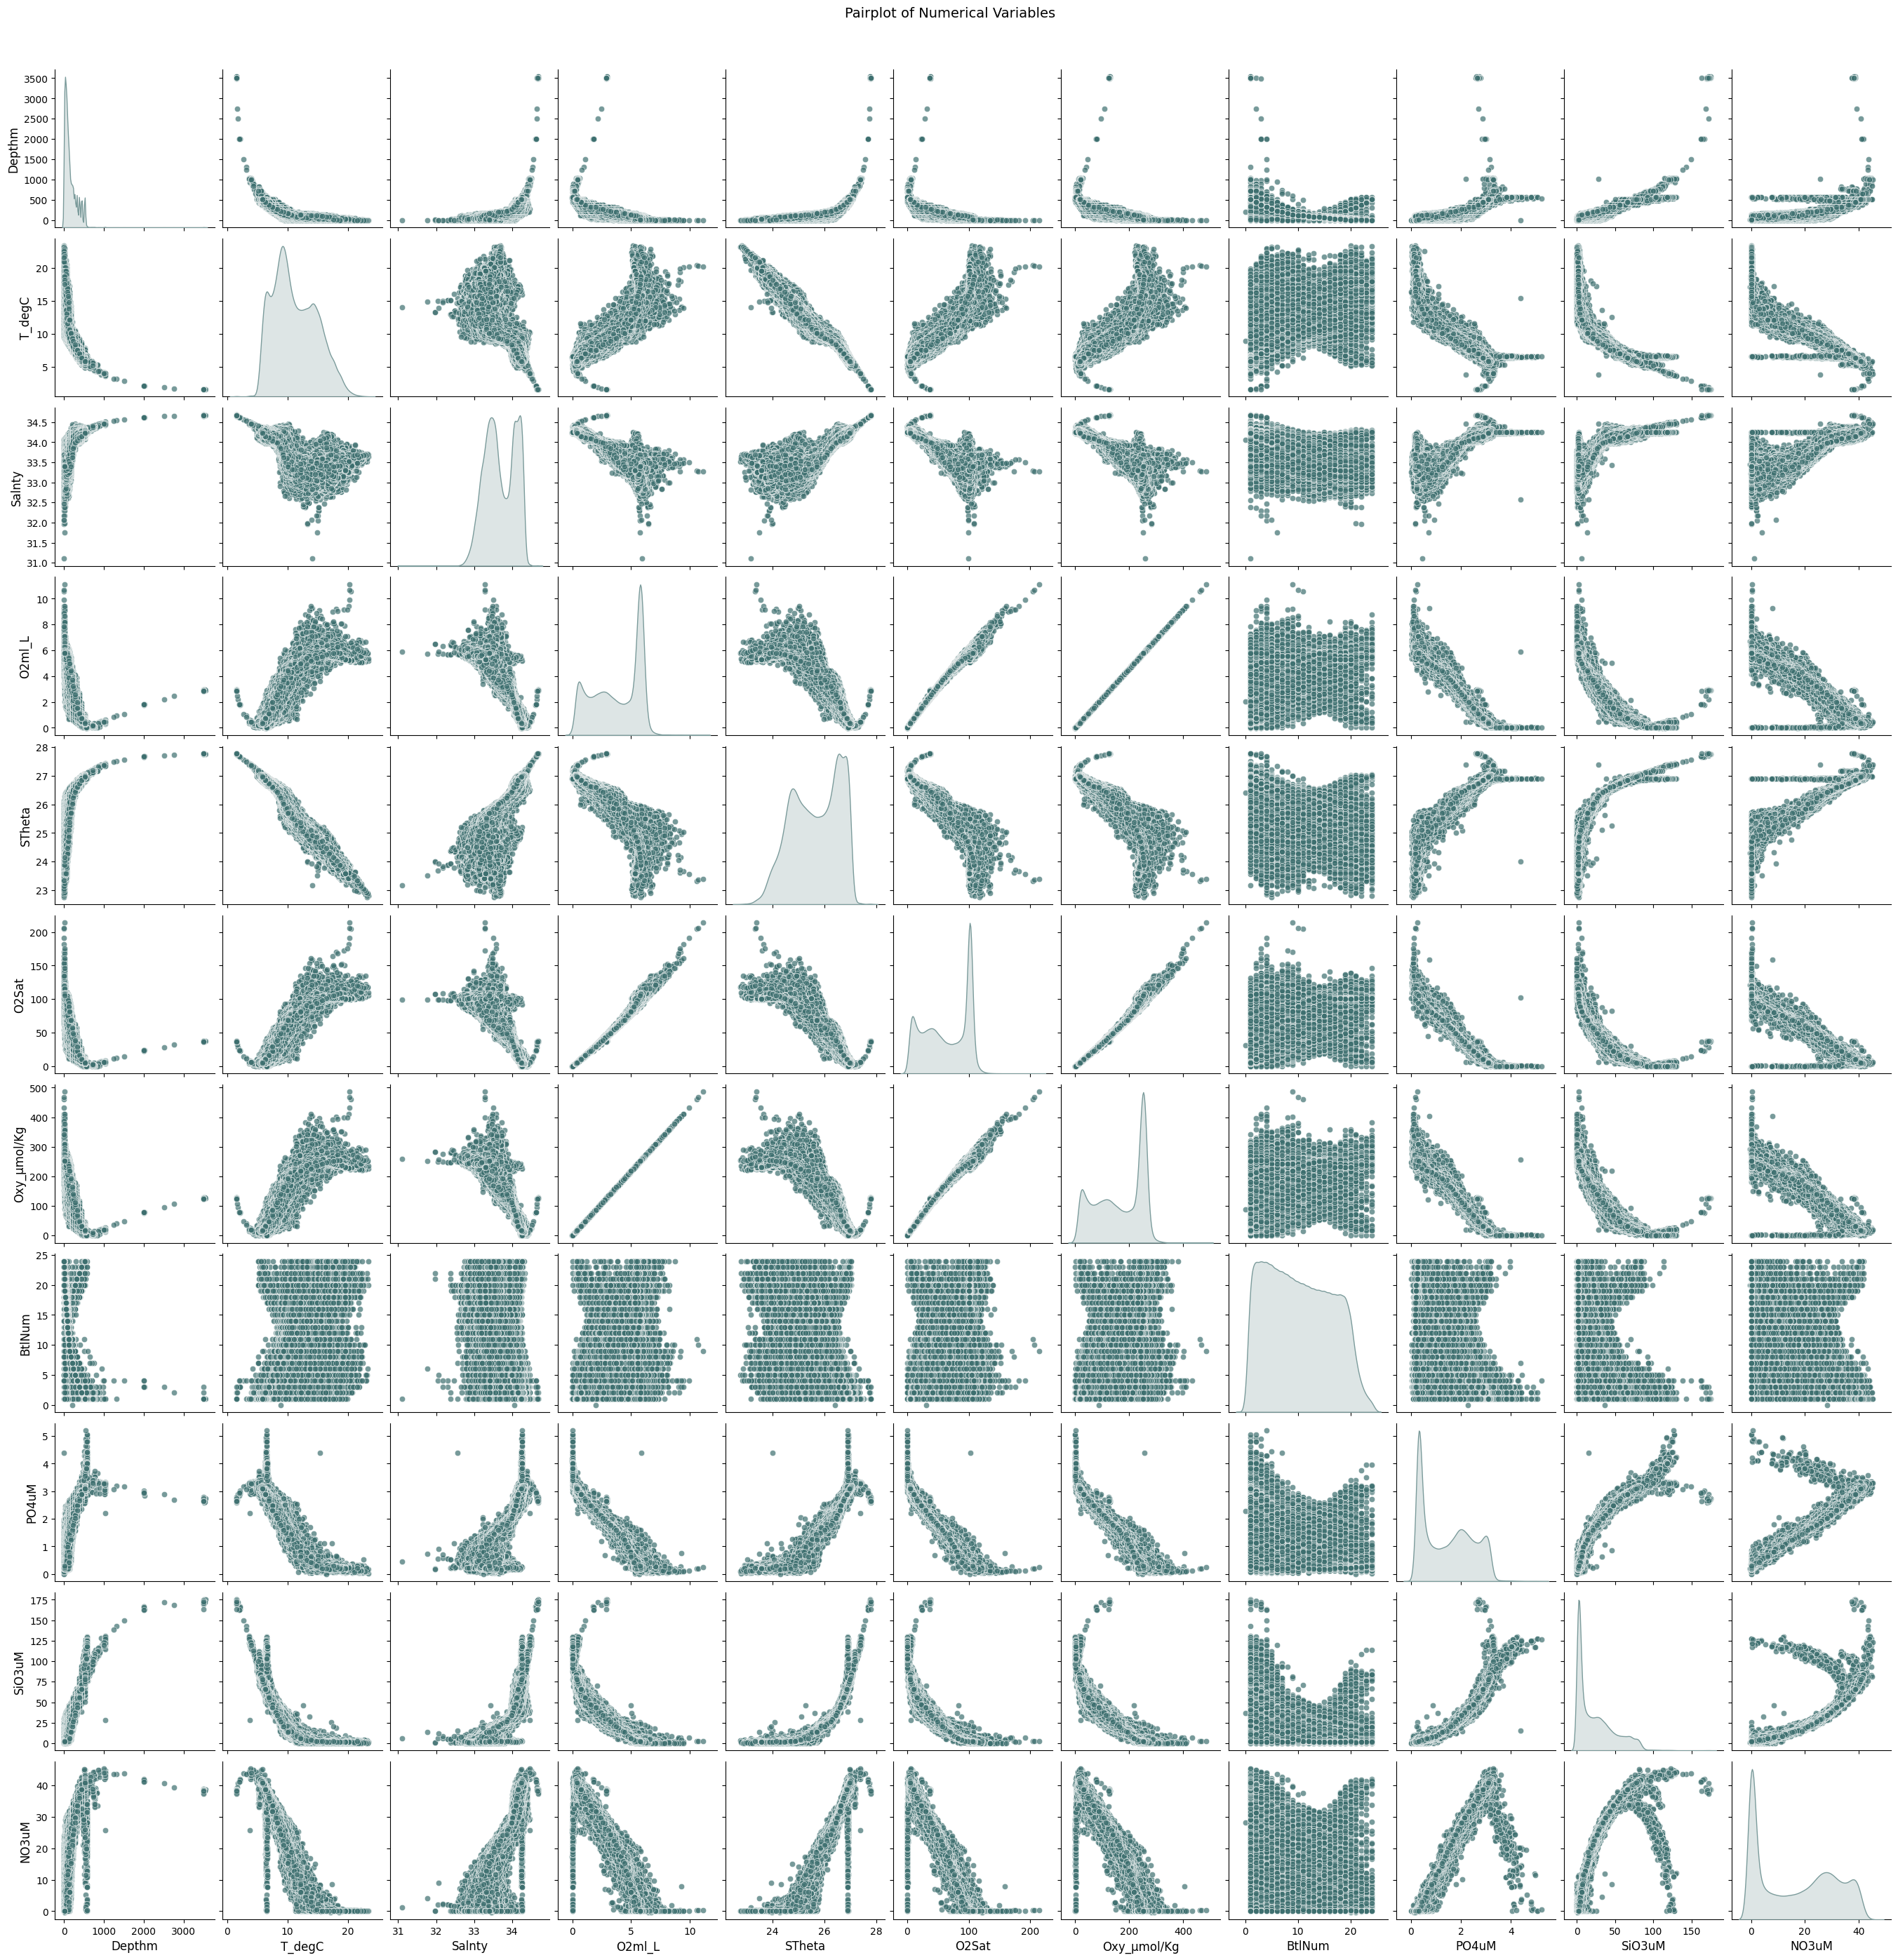

### Analysis of the Pairplot

#### Correlation

1. **Correlation Strength and Direction:**
   - The strength and direction of correlation can vary across the different plots. For example:
     - **TEMP vs. PRESS:** There is a strong nonlinear relationship, possibly because temperature decreases with increasing pressure in the oceanic context, indicating a negative correlation.
     - **OXYGEN vs. TEMP:** There appears to be a negative correlation, suggesting that higher temperatures might be associated with lower oxygen levels.

#### Outliers

2. **Identifying Outliers:**
   - Outliers are visible in several plots, such as in the PRESS variable with other attributes. Significant outliers could skew the regression model and should be investigated further to understand their causes.

#### Patterns and Clusters

3. **Clusters and Hidden Patterns:**
   - Some scatter plots exhibit clustering, which may suggest the influence of additional factors. For example, `TEMP` and `OXYGEN` exhibit cl

<IPython.core.display.Markdown object>

In [22]:
file_path="pairplot2.png"
plot_pairplot(df_cleaned,file_path)
prompt = """
The following graph represents a pairplot analyzing the relationship between different variables. Please examine the scatter plot and marginal distributions to identify any significant patterns, trends, or anomalies.

Describe the correlation strength and direction between the two variables.
Identify any outliers that could impact a regression model.
Look for clusters or hidden patterns that may indicate additional factors influencing the relationship.
Analyze the distribution of each variable to determine if transformations might be beneficial.
Discuss the implications of these findings in an oceanographic or climate-related context.
Provide a concise yet insightful interpretation, and suggest any next steps to refine the analysis further. 
"""
markdown_output = analyze_image(client, prompt, file_path)  # Store the output first
# Display Markdown properly without returning an object
display(Markdown(markdown_output))

In [23]:
selected_features=['Depthm', 'T_degC', 'O2ml_L', 'STheta', 'O2Sat',
       'Oxy_µmol/Kg', 'BtlNum', 'PO4uM', 'SiO3uM', 'NO3uM']
target_variable=['Salnty']
df_model=df_cleaned
df_model

Depthm  T_degC   Salnty  O2ml_L    STheta   O2Sat  Oxy_µmol/Kg  \
683767       1  14.260  33.3960   6.050  24.89400  103.80     263.6302   
683768       6  14.290  33.3960   6.060  24.88800  104.00     264.0675   
683770      12  14.300  33.4010   6.060  24.89000  104.00     264.0670   
683772      22  14.320  33.4060   6.030  24.89000  103.50     262.7597   
683774      31  14.230  33.4110   5.990  24.91300  102.70     261.0108   
...        ...     ...      ...     ...       ...     ...          ...   
864857     521   5.818  34.2382   0.366  26.98477    5.23      15.9500   
864859       2  18.744  33.4083   5.805  23.87072  108.74     253.4700   
864860       5  18.692  33.4150   5.796  23.88911  108.46     253.0600   
864861      10  18.161  33.4062   5.816  24.01426  107.74     253.9200   
864862      15  17.533  33.3880   5.774  24.15297  105.66     252.0800   

        BtlNum  PO4uM  SiO3uM  NO3uM  
683767     1.0   0.41    4.80   0.20  
683768     2.0   0.39    4.50   0.10  
683770     3.0   0.40    4.30   0.10  
683772     4.0   0.39    4.20   0.20  
683774     5.0   0.41    4.20   0.20  
...        ...    ...     ...    ...  
864857     1.0   3.09   77.58  40.98  
864859     4.0   0.22    1.77   0.10  
864860     3.0   0.20    1.75   0.09  
864861     2.0   0.25    1.99   0.11  
864862     1.0   0.31    2.58   0.14  

[109946 rows x 11 columns]

In [24]:
# Split into train and test sets (80% train, 20% test)
X = df_model[selected_features]
y = df_model[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [26]:
# Train Linear Regression Model
model = LinearRegression()
# Use RFECV to find the best number of features
rfecv = RFECV(
    estimator=model, 
    step=1,  # Remove one feature at a time
    scoring=make_scorer(r2_score),  # Use R² score to evaluate performance
    cv=5  # 5-fold cross-validation
)

# Fit RFECV
rfecv.fit(X_train, y_train)

# Get the optimal number of features
optimal_features = X_train.columns[rfecv.support_]
print(f"Optimal Number of Features: {rfecv.n_features_}")
print("Selected Features:", optimal_features.tolist())

Optimal Number of Features: 10
Selected Features: ['Depthm', 'T_degC', 'O2ml_L', 'STheta', 'O2Sat', 'Oxy_µmol/Kg', 'BtlNum', 'PO4uM', 'SiO3uM', 'NO3uM']


C:\Users\jmsm\AppData\Local\Temp\ipykernel_33012\2351293053.py:275: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=num_features, x=scores, palette=colors, edgecolor='white', orient='h')


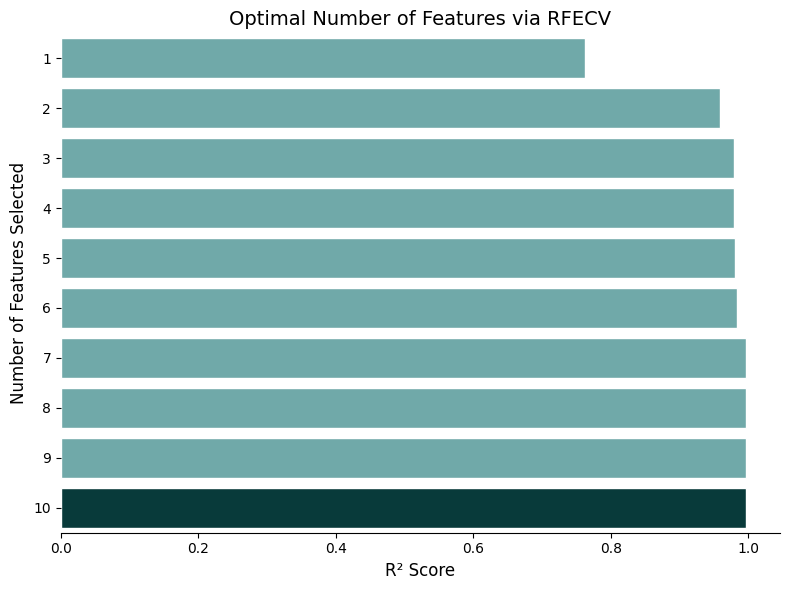

In [27]:
file_path="rfecv.png"
plot_rfecv_results(rfecv, file_path)

## Generating & Evaluating the model

In [29]:
# Ensure the dataset only contains selected features and target variable, dropping NaN values
features=['Depthm', 'T_degC', 'O2ml_L', 'STheta', 'O2Sat', 'Oxy_µmol/Kg', 'BtlNum', 'PO4uM', 'SiO3uM', 'NO3uM','Salnty']
selected_features=['Depthm', 'T_degC', 'O2ml_L', 'STheta', 'O2Sat', 'Oxy_µmol/Kg', 'BtlNum', 'PO4uM', 'SiO3uM', 'NO3uM']
target_var=['Salnty']
df_model = df_filtered[features].dropna()
df_model

Depthm  T_degC  O2ml_L    STheta   O2Sat  Oxy_µmol/Kg  BtlNum  PO4uM  \
683767       1  14.260   6.050  24.89400  103.80     263.6302     1.0   0.41   
683768       6  14.290   6.060  24.88800  104.00     264.0675     2.0   0.39   
683770      12  14.300   6.060  24.89000  104.00     264.0670     3.0   0.40   
683772      22  14.320   6.030  24.89000  103.50     262.7597     4.0   0.39   
683774      31  14.230   5.990  24.91300  102.70     261.0108     5.0   0.41   
...        ...     ...     ...       ...     ...          ...     ...    ...   
864857     521   5.818   0.366  26.98477    5.23      15.9500     1.0   3.09   
864859       2  18.744   5.805  23.87072  108.74     253.4700     4.0   0.22   
864860       5  18.692   5.796  23.88911  108.46     253.0600     3.0   0.20   
864861      10  18.161   5.816  24.01426  107.74     253.9200     2.0   0.25   
864862      15  17.533   5.774  24.15297  105.66     252.0800     1.0   0.31   

        SiO3uM  NO3uM   Salnty  
683767    4.80   0.20  33.3960  
683768    4.50   0.10  33.3960  
683770    4.30   0.10  33.4010  
683772    4.20   0.20  33.4060  
683774    4.20   0.20  33.4110  
...        ...    ...      ...  
864857   77.58  40.98  34.2382  
864859    1.77   0.10  33.4083  
864860    1.75   0.09  33.4150  
864861    1.99   0.11  33.4062  
864862    2.58   0.14  33.3880  

[109946 rows x 11 columns]

In [30]:
# Define features and target
X = df_model[selected_features]
y = df_model[target_var]

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)


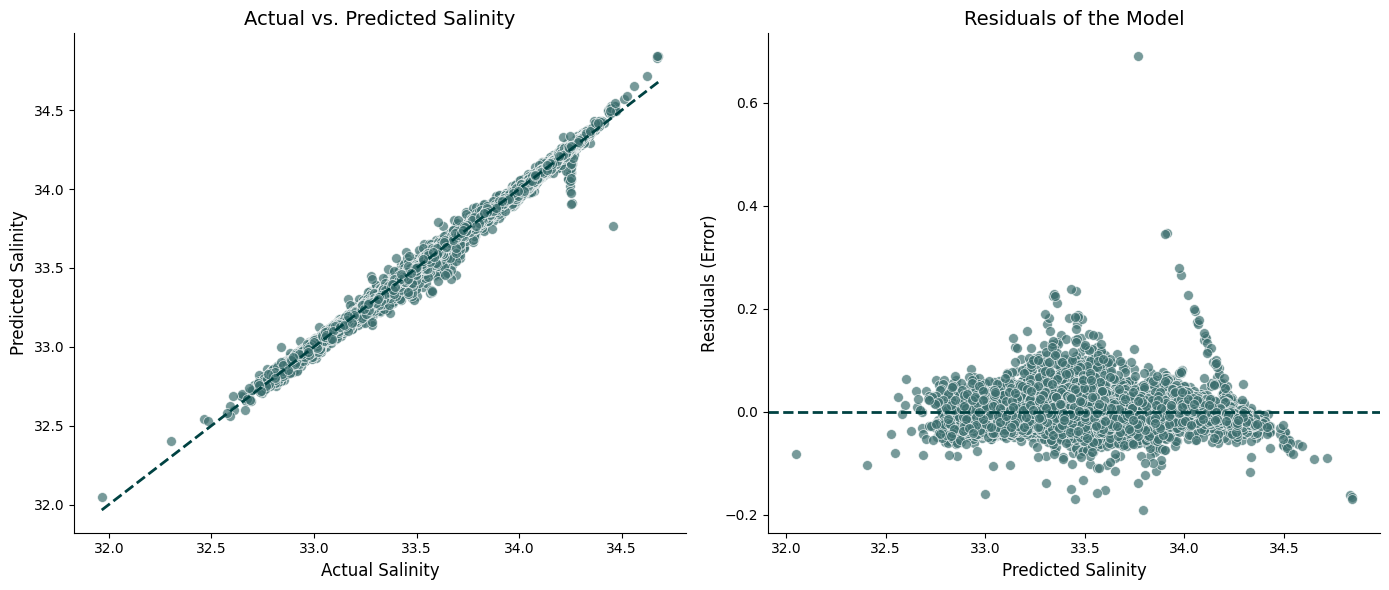

### Model Performance Evaluation

1. **Alignment of Predicted and Actual Values**:
   - The predicted values closely align with the actual values along a diagonal line, indicating good performance in capturing the overall trend.

2. **Systematic Deviations**:
   - There are minor deviations visible where predictions slightly diverge from actual values, especially at higher salinity levels, suggesting potential overprediction.

3. **Bias and Consistent Errors**:
   - The line is slightly more aligned towards the lower salinity values, hinting at a small bias where the model may underpredict low values and overpredict high values.

### Residual Analysis

1. **Distribution of Residuals**:
   - The residuals are clustered around zero, indicating that errors are generally randomly distributed.

2. **Patterns and Heteroscedasticity**:
   - Sparse patterns hint at slight heteroscedasticity as variance increases at higher predicted values. Residuals fan out slightly more at both ends.

3. **No

<IPython.core.display.Markdown object>

In [31]:
file_path="model_evaluation_multivariable.png"
plot_model_evaluation(y_test.values.flatten(), y_pred.flatten(), file_path)
prompt = """
The following graph represents the **Actual vs. Predicted values** and the **Residuals** of a regression model. 

### **Analysis Required:**
1️⃣ **Model Performance Evaluation**:
   - Assess how well the **predicted values align with the actual values**.
   - Identify whether there are **systematic deviations** (e.g., underprediction or overprediction in certain ranges).
   - Discuss if the model exhibits **bias** or consistent errors.

2️⃣ **Residual Analysis**:
   - Examine the **distribution of residuals** to determine whether errors are randomly distributed.
   - Identify any **patterns, heteroscedasticity (variance changes), or skewness**.
   - Assess if residuals indicate **non-linearity**, suggesting the need for a different modeling approach.

3️⃣ **Error Insights**:
   - Identify potential **outliers** that may be influencing the model.
   - Discuss whether the model suffers from **overfitting or underfitting** based on residual behavior.
   - Evaluate whether **additional features or transformations** could improve the model's accuracy.

4️⃣ **Real-World Implications**:
   - How do the observed errors impact decision-making or predictions in the given context (e.g., climate studies, environmental forecasting, business insights)?
   - If the model is deployed, what are the risks associated with its error patterns?

Please provide a **structured and detailed analysis** based on these insights.
"""

markdown_output = analyze_image(client, prompt, file_path)  # Store the output first
# Display Markdown properly without returning an object
display(Markdown(markdown_output))

In [32]:
# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Raíz cuadrada del MSE
r2 = r2_score(y_test, y_pred)

print(f"📊 Evaluating the model:")
print(f"🔹 Mean Absolute Error (MAE): {mae:.3f}")
print(f"🔹 Mean Squared Error (MSE): {mse:.3f}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"🔹 R² Score: {r2:.3f}")

# Cross-validation to check model stability
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R² Score: {cv_scores.mean():.4f}")

📊 Evaluating the model:
🔹 Mean Absolute Error (MAE): 0.017
🔹 Mean Squared Error (MSE): 0.001
🔹 Root Mean Squared Error (RMSE): 0.024
🔹 R² Score: 0.996
Cross-Validation R² Scores: [0.99451373 0.99666405 0.99661075 0.99649491 0.70598171]
Mean CV R² Score: 0.9381


In [33]:
prompt = f"""
The following equation represents a linear regression model that describes the relationship between salinity and temperature:

{text}

### Model Performance Metrics:
- **Mean Absolute Error (MAE)**: {mae:.3f}
- **Mean Squared Error (MSE)**: {mse:.3f}
- **Root Mean Squared Error (RMSE)**: {rmse:.3f}
- **R² Score (Coefficient of Determination)**: {r2:.3f}
- **Mean Cross-Validation R² Score**: {cv_scores.mean():.4f}

### Analysis Required:
1️⃣ **Interpretation of Model Components**:
   - Explain the meaning of the **slope** and **intercept**, and how they influence salinity predictions.
   - Discuss whether the relationship is **positive or negative** and its implications.

2️⃣ **Model Performance Evaluation**:
   - Assess the **accuracy and reliability** of the model based on the given performance metrics.
   - What do the MAE, MSE, RMSE, and R² values suggest about the model’s predictive power?
   - Compare the **train-test R² score** with the **cross-validation R² score**:
     - Does the cross-validation score indicate that the model generalizes well?
     - Are there signs of **overfitting (high R² but low CV score)** or **underfitting (low R² and low CV score)**?

3️⃣ **Limitations and Assumptions**:
   - What are the potential **limitations** of using a linear regression approach for this relationship?
   - Does the model assume a **strictly linear** relationship, and is this valid for oceanographic data?
   - Could **collinearity or missing factors** affect the predictions?

4️⃣ **Real-World Implications**:
   - How does this relationship between temperature and salinity relate to **oceanographic, climate, or environmental** studies?
   - Could external factors (e.g., depth, pressure, currents) influence salinity beyond just temperature?
   - How well can this model be applied to **real-world oceanic predictions**?

5️⃣ **Potential Model Improvements**:
   - Would a **higher-order regression** (quadratic or polynomial) provide a better fit?
   - Should additional **predictor variables** be included to improve accuracy?
   - How can **feature selection or regularization techniques** (Lasso, Ridge) be used to refine the model?

Please provide a **detailed, structured, and insightful analysis** of this model, including the implications of the cross-validation score.
"""
analyze_text(client, prompt)

### 1️⃣ Interpretation of Model Components:

- **Slope (-0.055)**: The slope indicates that for each 1-degree increase in temperature, the salinity decreases by 0.055 units. This negative slope suggests an inverse relationship, meaning higher temperatures are associated with lower salinity levels.

- **Intercept (34.441)**: The intercept is the expected salinity when the temperature is zero. While this value provides a starting reference point for the model, it might not have a real-world equivalent since a temperature of zero degrees might not occur in the context of your data.

- **Relationship**: The negative relationship implies that as the water warms, its ability to retain salt decreases, which could be due to increased evaporation or changes in water density.

### 2️⃣ Model Performance Evaluation:

- **Accuracy and Reliability**: 
  - **MAE (0.017)**: Shows the average magnitude of error, indicating that the average prediction error is 0.017 units. 
  - **MSE (0.001)** and **RMS